In [1]:
!ls

detectron2_duckie.ipynb  duckie_sim_val2.json  output
duckie_real_train.json	 duckie_to_coco.ipynb  __pycache__
duckie_real_val.json	 input.jpg	       utils.py


# Getting Started
In the same folder as this repository, create a "data" folder, or a symbolic link to where you store the data.

In [2]:
from utils import DuckieVisualizer

In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow
from cv2_plt_imshow import cv2_plt_imshow as cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

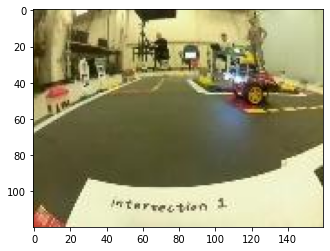

In [4]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("../data/dt_segmentation_dataset/real/imgs/frame0.jpg")
cv2_imshow(im)

In [5]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

/home/raphael/anaconda3/lib/python3.8/site-packages/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629395347/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


In [6]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([ 0, 62], device='cuda:0')
Boxes(tensor([[64.8575, 12.3402, 74.7061, 33.4640],
        [82.5865, 19.8824, 91.0546, 28.4474]], device='cuda:0'))


## Show a sample image from the dataset. 

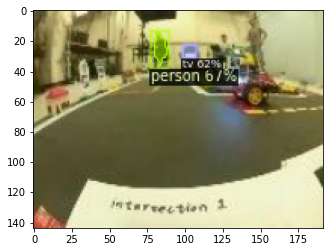

In [7]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

## Register COCO datasets
This assumes that the original dataset was converted from its original format to MS COCO using the "duckie_to_coco.ipynb" dataset, or downloaded from here.
- http://www.raphaeljean.com/files/duckie_sim_train.json
- http://www.raphaeljean.com/files/duckie_sim_val.json
- http://www.raphaeljean.com/files/dt_segmentation_dataset.zip



In [8]:
#!wget http://www.raphaeljean.com/files/duckie_sim_train.json
#!wget http://www.raphaeljean.com/files/duckie_sim_val.json
#!wget http://www.raphaeljean.com/files/dt_segmentation_dataset.zip

In [9]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("duckie_train", {}, "../data/duckie_sim_train.json", "../data/dt_segmentation_dataset/sim/rgb_160_120/")
register_coco_instances("duckie_val", {}, "../data/duckie_sim_val.json", "../data/dt_segmentation_dataset/sim/rgb_160_120/")
register_coco_instances("duckie_real_train", {}, "../data/duckie_real_train.json", "../data/dt_segmentation_dataset/real/imgs/")
register_coco_instances("duckie_real_val", {}, "../data/duckie_real_val.json", "../data/dt_segmentation_dataset/real/imgs/")
from detectron2.structures import BoxMode
#from utils import DuckieVisualizer

[11/16 20:21:59 d2.data.datasets.coco]: Loading ../data/duckie_sim_train.json takes 5.08 seconds.
[11/16 20:21:59 d2.data.datasets.coco]: Loaded 50000 images in COCO format from ../data/duckie_sim_train.json


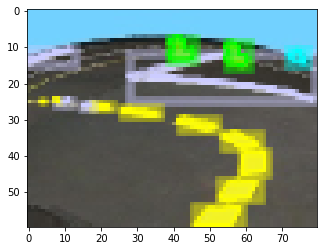

In [10]:
#dataset_dicts = get_balloon_dicts("balloon/train")
dataset_dicts = DatasetCatalog.get("duckie_train")
duckie_metadata = MetadataCatalog.get("duckie_train")
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import GenericMask, _create_text_labels

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = DuckieVisualizer(img[:, :, ::-1], metadata=duckie_metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])
    #print(d)

[11/16 20:23:34 d2.data.datasets.coco]: Loaded 175 images in COCO format from ../data/duckie_real_train.json


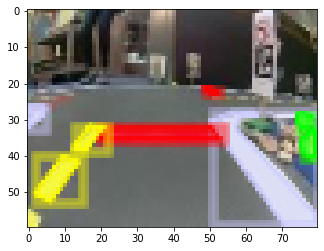

In [27]:
#dataset_dicts = get_balloon_dicts("balloon/train")
dataset_dicts = DatasetCatalog.get("duckie_real_train")
duckie_metadata = MetadataCatalog.get("duckie_real_train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = DuckieVisualizer(img[:, :, ::-1], metadata=duckie_metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])
    #print(d)

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("duckie_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 6
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 3000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [12]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = "../output/model_final.pth"  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[11/16 20:09:24 d2.data.datasets.coco]: Loading ../data/duckie_sim_val.json takes 1.11 seconds.
[11/16 20:09:24 d2.data.datasets.coco]: Loaded 9559 images in COCO format from ../data/duckie_sim_val.json
AFasa
AFasa
AFasa


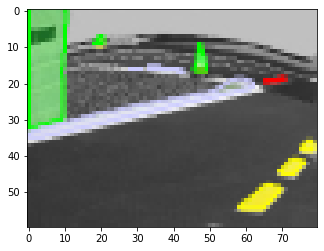

In [16]:

import types
import numpy as np
from utils import DuckieVisualizer
from detectron2.utils.visualizer import ColorMode
#dataset_dicts = get_balloon_dicts("balloon/val")
dataset_dicts = DatasetCatalog.get("duckie_val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = DuckieVisualizer(im[:, :, ::-1],
                   metadata=duckie_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    #v.draw_instance_predictions = types.MethodType(custom_draw_instance_predictions, v)
    #v.draw_instance_predictions=custom_draw_instance_predictions
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [17]:

from detectron2.utils.visualizer import ColorMode
im = cv2.imread("../data/dt_segmentation_dataset/real/imgs/frame1451.jpg")
#cv2_imshow(im)

AFasa


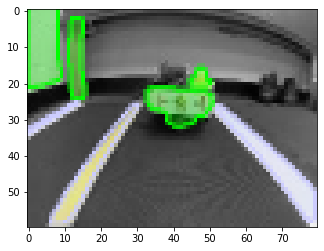

In [18]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.55   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = DuckieVisualizer(im[:, :, ::-1],
               metadata=duckie_metadata, 
               scale=0.5, 
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
#v.draw_instance_predictions = types.MethodType(custom_draw_instance_predictions, v)
#v.draw_instance_predictions=custom_draw_instance_predictions
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])